# Knowledge distillation


### installing dependencies


In [ ]:
%pip install -r requirements.txt

### kagglehub


In [1]:
import kagglehub
kagglehub.login()  

## 1. Imports and defaults


In [ ]:
import os
import numpy as np
import torch
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import requests
import kagglehub
from io import StringIO

# ============================
# CONFIG — change these values
# ============================
KAGGLE_USERNAME     = "farerabr"           # your Kaggle username
TRAIN_DATASET       = "persian-wikipedia-sentences"  # Kaggle dataset name (e.g. "farerabr/persian-wikipedia-sentences")
EMBEDDINGS_DATASET  = "persian-sentence-embedded-jina-v3"  # name for the output dataset with embeddings
# ==============================

# --- Config
EPOCHS          = 30
PATIENCE        = 3
BATCH_SIZE      = 256
LR_STUDENT      = 2e-5
LR_PROJ         = 5e-3
TEMPERATURE     = 0.05
TEACHER_MODEL   = 'jinaai/jina-embeddings-v3'
STUDENT_MODEL   = 'HooshvareLab/bert-fa-base-uncased'

# --- Paths 
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
EMB_DIR  = os.path.join(BASE_DIR, 'embeddings')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
CHECKPOINT_DIR  = os.path.join(MODEL_DIR, 'checkpoints')

for d in [DATA_DIR, EMB_DIR, MODEL_DIR, CHECKPOINT_DIR]:
    os.makedirs(d, exist_ok=True)
    
print("Base directory:", BASE_DIR)

# --- Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
else:
    print('No GPU found — make sure you are on Colab with GPU runtime for teacher inference')

Base directory: /root/embed-distill
Device: cuda
GPU: NVIDIA GeForce RTX 3090
VRAM: 25.3 GB


---

## 2. Data loading


In [15]:
# Download dataset from Kaggle
path = kagglehub.dataset_download(f"{KAGGLE_USERNAME}/{TRAIN_DATASET}", output_dir=DATA_DIR)
print(f'Dataset downloaded to: {path}')

# Load all batch files
all_sentences = []
batch_files = sorted([f for f in os.listdir(DATA_DIR) if f.startswith('persian_sentences_batch')])
print(f'Found {len(batch_files)} batch files')

for batch_file in batch_files:
    file_path = os.path.join(DATA_DIR, batch_file)
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f if line.strip()]
    all_sentences.extend(sentences)
    print(f'  Loaded {batch_file}: {len(sentences):,} sentences')

print(f'\nTotal sentences loaded: {len(all_sentences):,}')


# --- Train/Val split (95/5)
train_sentences, val_sentences = train_test_split(
    all_sentences,
    test_size=0.05,
    random_state=42
)

print(f'Train: {len(train_sentences):,}')
print(f'Val:   {len(val_sentences):,}')

# --- Save splits locally
for name, split in [('train', train_sentences), ('val', val_sentences)]:
    save_path = os.path.join(DATA_DIR, f'{name}_sentences.txt')
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(split))
    size = os.path.getsize(save_path) / 1e6
    print(f'Saved {name} → {save_path} ({size:.1f} MB)')

100%|███████████████████████████████████████████████████████| 295M/295M [00:12<00:00, 24.4MB/s]

Extracting files...


Dataset downloaded to: /root/embed-distill/data
Found 5 batch files
  Loaded persian_sentences_batch1.txt: 972,642 sentences
  Loaded persian_sentences_batch2.txt: 979,907 sentences
  Loaded persian_sentences_batch3.txt: 982,530 sentences
  Loaded persian_sentences_batch4.txt: 966,101 sentences
  Loaded persian_sentences_batch5.txt: 972,442 sentences

Total sentences loaded: 4,873,622
Train: 4,629,940
Val:   243,682
Saved train → /root/embed-distill/data/train_sentences.txt (1017.3 MB)
Saved val → /root/embed-distill/data/val_sentences.txt (53.6 MB)


---

## 3. Teacher embedding(jina-v3)


In [ ]:
# --- Config
SAVE_EVERY = 50_000    # checkpoint every 50K (more efficient with large dataset)

# --- Load teacher
print("Loading Jina-v3 teacher model...")
teacher = SentenceTransformer(
    TEACHER_MODEL,
    device=device,
    trust_remote_code=True,  # allow loading custom code from Hugging Face (required for Jina-v3)
)

print(f"Teacher embedding dim: {teacher.get_sentence_embedding_dimension()}")

# --- Load train sentences
with open(os.path.join(DATA_DIR, 'train_sentences.txt'), 'r', encoding='utf-8') as f:
    train_sentences = [l.strip() for l in f if l.strip()]
print(f"Sentences to embed: {len(train_sentences):,}")

# --- Resume support
emb_path   = os.path.join(EMB_DIR, 'train_embeddings.npy')
index_path = os.path.join(EMB_DIR, 'train_embedded_count.txt')

if os.path.exists(index_path) and os.path.exists(emb_path):
    with open(index_path) as f:
        start_idx = int(f.read().strip())
    embeddings = []  # start empty, existing data is in the file
    print(f"Resuming from sentence {start_idx:,}")
else:
    start_idx  = 0
    embeddings = []
    print("Starting fresh")

# --- Generate embeddings
torch.cuda.empty_cache()
total_saved = start_idx  # track true total across all checkpoints
teacher.eval()
with torch.no_grad():
    for i in tqdm(range(start_idx, len(train_sentences), BATCH_SIZE), desc='Embedding'):
        batch = train_sentences[i : i + BATCH_SIZE]
        embs  = teacher.encode(
            batch,
            task='text-matching',
            batch_size=BATCH_SIZE,
            show_progress_bar=False,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        embeddings.extend(embs)
        total_saved += len(embs)

        # Checkpoint
        if len(embeddings) >= SAVE_EVERY:
            chunk_idx = total_saved // SAVE_EVERY
            chunk_path = os.path.join(EMB_DIR, f'train_embeddings_chunk{chunk_idx}.npy')
            np.save(chunk_path, np.array(embeddings))
            with open(index_path, 'w') as f:
                f.write(str(total_saved))
            print(f'Chunk {chunk_idx} saved: {total_saved:,}')

            embeddings = []
            torch.cuda.empty_cache()

# Save final remaining chunk
if embeddings:
    chunk_idx = (total_saved // SAVE_EVERY) + 1
    chunk_path = os.path.join(EMB_DIR, f'train_embeddings_chunk{chunk_idx}.npy')
    np.save(chunk_path, np.array(embeddings))
    print(f'\n✅ Done! Total: {total_saved:,}')
    
# Val Embeddings
with open(os.path.join(DATA_DIR, 'val_sentences.txt'), 'r', encoding='utf-8') as f:
    val_sentences = [l.strip() for l in f if l.strip()]
print(f"Val sentences to embed: {len(val_sentences):,}")

val_emb_path = os.path.join(EMB_DIR, 'val_embeddings.npy')

val_embeddings = teacher.encode(
    val_sentences,
    task='text-matching',
    batch_size=BATCH_SIZE,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

np.save(val_emb_path, val_embeddings)
print(f"\n✅ Done!")
print(f"Val embeddings shape: {val_embeddings.shape}")
print(f"Saved to: {val_emb_path}")

Loading Jina-v3 teacher model...


`torch_dtype` is deprecated! Use `dtype` instead!
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyT

Loading weights:   0%|          | 0/492 [00:00<?, ?it/s]

Teacher embedding dim: 1024
Sentences to embed: 4,629,940
Resuming from sentence 1,153,536


Embedding:   0%|          | 0/13580 [00:00<?, ?it/s]

In [ ]:
# Merge existing + new chunks
import glob
all_files = sorted(glob.glob(os.path.join(EMB_DIR, 'train_embeddings_chunk*.npy')))

# Also include the original 150K file
parts = [np.load(os.path.join(EMB_DIR, 'train_embeddings.npy'))]  # existing 150K
parts += [np.load(f) for f in all_files]                           # new chunks

final = np.concatenate(parts)
np.save(os.path.join(EMB_DIR, 'train_embeddings_final.npy'), final)
print(f'Final shape: {final.shape}')

### 3.1. Upload embeddings to kaggle

This is not mandatory. Do as you please.


In [ ]:
print("Uploading embeddings to Kaggle...")
kagglehub.dataset_upload(
    handle=f"{KAGGLE_USERNAME}/{EMBEDDINGS_DATASET}",  # private dataset
    local_dataset_dir=EMB_DIR,
)
print("✅ Embeddings uploaded to Kaggle!")

In [2]:
# Generate real teacher embeddings for sanity check (local 3050Ti)
from sentence_transformers import SentenceTransformer
import numpy as np

# Load teacher
teacher = SentenceTransformer(
    TEACHER_MODEL, 
    trust_remote_code=True, 
    device=device,
    )

# Load sentences
with open('./data/train_sentences.txt') as f:
    test_train_sentences = [l.strip() for l in f if l.strip()][:1000]
with open('./data/val_sentences.txt') as f:
    test_val_sentences = [l.strip() for l in f if l.strip()][:100]

# Embed train
print("Embedding train sentences...")
test_train_embeddings = teacher.encode(
    test_train_sentences,
    task='text-matching',
    batch_size=16,
    normalize_embeddings=True,
    convert_to_numpy=True,
    show_progress_bar=True
)

# Embed val
print("Embedding val sentences...")
test_val_embeddings = teacher.encode(
    test_val_sentences,
    task='text-matching',
    batch_size=16,
    normalize_embeddings=True,
    convert_to_numpy=True,
    show_progress_bar=True
)

print(f"Train embeddings: {test_train_embeddings.shape}")
print(f"Val embeddings:   {test_val_embeddings.shape}")

np.save('./embeddings/train_embeddings_test.npy', test_train_embeddings)
np.save('./embeddings/val_embeddings_test.npy', test_val_embeddings)
print("Saved ✅")

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Embedding train sentences...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Embedding val sentences...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Train embeddings: (1000, 1024)
Val embeddings:   (100, 1024)
Saved ✅


## Sanity Check -- remove before pushing


In [5]:
# ============================================================
# SANITY CHECK — 1000 samples, 5 epochs, verify training works
# ============================================================
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime

# --- Config
SANITY_EPOCHS   = 5
SANITY_BATCH    = 16        # small for 3050Ti
TEMPERATURE     = 0.05      # fixed from 4.0
STUDENT_MODEL   = './models/bert-fa'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Load test data
with open('./data/train_sentences.txt') as f:
    sanity_train_sentences = [l.strip() for l in f if l.strip()][:1000]
with open('./data/val_sentences.txt') as f:
    sanity_val_sentences = [l.strip() for l in f if l.strip()][:100]

sanity_train_emb = np.load('./embeddings/train_embeddings_test.npy')
sanity_val_emb   = np.load('./embeddings/val_embeddings_test.npy')

print(f"Train: {len(sanity_train_sentences)} sentences, {sanity_train_emb.shape}")
print(f"Val:   {len(sanity_val_sentences)} sentences, {sanity_val_emb.shape}")

# --- Dataset
class DistillationDataset(Dataset):
    def __init__(self, sentences, embeddings):
        self.sentences  = sentences
        self.embeddings = embeddings

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        return self.sentences[idx], emb

train_dataset = DistillationDataset(sanity_train_sentences, sanity_train_emb)
val_dataset   = DistillationDataset(sanity_val_sentences,   sanity_val_emb)

train_loader = DataLoader(train_dataset, batch_size=SANITY_BATCH, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=SANITY_BATCH, shuffle=False, num_workers=0, pin_memory=False)

# --- Model
tokenizer  = AutoTokenizer.from_pretrained(STUDENT_MODEL)
student    = AutoModel.from_pretrained(STUDENT_MODEL).to(device)
projection = nn.Linear(student.config.hidden_size, 1024).to(device)

# --- Loss
kl_criterion = torch.nn.KLDivLoss(reduction='batchmean')

def distillation_loss(student_emb, teacher_emb, temperature=TEMPERATURE):
    # 1. Direct cosine alignment loss (main signal)
    cosine_loss = (1 - F.cosine_similarity(student_emb, teacher_emb, dim=-1)).mean()
    
    # 2. KL similarity matrix loss (relational structure)
    student_sim = torch.mm(student_emb, student_emb.T) / temperature
    teacher_sim = torch.mm(teacher_emb, teacher_emb.T) / temperature
    kl = kl_criterion(
        F.log_softmax(student_sim, dim=-1),
        F.softmax(teacher_sim, dim=-1)
    )
    
    # Combined loss
    return cosine_loss + kl

def mean_pool(token_embeds, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    return torch.sum(token_embeds * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

# --- Optimizer with separate LRs
optimizer = AdamW([
    {'params': student.parameters(),    'lr': 2e-5},
    {'params': projection.parameters(), 'lr': 5e-3}
], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=SANITY_EPOCHS, eta_min=1e-6)
scaler    = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'sim': []}
# --- Training loop
for epoch in range(1, SANITY_EPOCHS + 1):

    # Train
    student.train()
    projection.train()
    train_loss = 0.0

    for sentences, teacher_embs in tqdm(train_loader, desc=f'Epoch {epoch} Train'):
        teacher_embs = teacher_embs.to(device)
        optimizer.zero_grad()

        encoded = tokenizer(
            list(sentences),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        with autocast(device_type='cuda'):
            output      = student(**encoded)
            student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
            student_emb = projection(student_emb)
            student_emb = F.normalize(student_emb, dim=-1)
            loss        = distillation_loss(student_emb, teacher_embs)

        train_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(list(student.parameters()) + list(projection.parameters()), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validate
    student.eval()
    projection.eval()
    val_loss = 0.0

    with torch.no_grad():
        for sentences, teacher_embs in tqdm(val_loader, desc=f'Epoch {epoch} Val'):
            teacher_embs = teacher_embs.to(device)
            encoded = tokenizer(
                list(sentences),
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors='pt'
            ).to(device)

            with autocast(device_type='cuda'):
                output      = student(**encoded)
                student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
                student_emb = projection(student_emb)
                student_emb = F.normalize(student_emb, dim=-1)
                val_loss   += distillation_loss(student_emb, teacher_embs).item()

    avg_val_loss = val_loss / len(val_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    print(f"Epoch {epoch:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # --- Check cosine similarity
    student.eval()
    projection.eval()
    with torch.no_grad():
        sample_sentences = sanity_val_sentences[:50]
        encoded = tokenizer(
            sample_sentences,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)
        output      = student(**encoded)
        student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
        student_emb = projection(student_emb)
        student_emb = F.normalize(student_emb, dim=-1)
        teacher_sample = torch.tensor(sanity_val_emb[:50], dtype=torch.float32).to(device)
        cos_sim = F.cosine_similarity(student_emb, teacher_sample, dim=-1)
        history['sim'].append(cos_sim.mean().item())
        print(f"  Cosine similarity: {cos_sim.mean():.4f} (target: >0.8)")

timestamp = datetime.now().strftime("%d-%H-%M-%S")
history_df = pd.DataFrame(history)
BASE_DIR = os.getcwd()
SANITY_DIR = os.path.join(BASE_DIR, 'sanity_check')
os.makedirs(SANITY_DIR, exist_ok=True)
history_df.to_csv(os.path.join(SANITY_DIR, f'{timestamp}-sanity_history.csv'), index=True, float_format='%.4f')
print(f"Sanity check history saved to: {os.path.join(SANITY_DIR, f'{timestamp}-sanity_history.csv')}")
print("\n✅ Sanity check complete!")

Train: 1000 sentences, (1000, 1024)
Val:   100 sentences, (100, 1024)


Epoch 1 Train:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 01 | Train: 0.6202 | Val: 0.4458
  Cosine similarity: 0.5484 (target: >0.8)


Epoch 2 Train:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 02 | Train: 0.3714 | Val: 0.4038
  Cosine similarity: 0.5895 (target: >0.8)


Epoch 3 Train:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 03 | Train: 0.3013 | Val: 0.3908
  Cosine similarity: 0.6023 (target: >0.8)


Epoch 4 Train:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 04 | Train: 0.2557 | Val: 0.3897
  Cosine similarity: 0.6029 (target: >0.8)


Epoch 5 Train:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 05 | Train: 0.2291 | Val: 0.3885
  Cosine similarity: 0.6047 (target: >0.8)
Sanity check history saved to: /win_d/Programming/embed-distill/sanity_check/25-20-36-06-sanity_history.csv

✅ Sanity check complete!


In [4]:
# Check what the student is actually outputting
student.eval()
projection.eval()
with torch.no_grad():
    encoded = tokenizer(
        sanity_val_sentences[:10],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    ).to(device)
    output      = student(**encoded)
    student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
    print(f"After mean pool - mean: {student_emb.mean():.4f}, std: {student_emb.std():.4f}")
    student_emb = projection(student_emb)
    print(f"After projection - mean: {student_emb.mean():.4f}, std: {student_emb.std():.4f}")
    student_emb = F.normalize(student_emb, dim=-1)
    print(f"After normalize - mean: {student_emb.mean():.4f}, std: {student_emb.std():.4f}")
    
    teacher_sample = torch.tensor(sanity_val_emb[:10], dtype=torch.float32).to(device)
    print(f"Teacher - mean: {teacher_sample.mean():.4f}, std: {teacher_sample.std():.4f}")
    
    cos_sim = F.cosine_similarity(student_emb, teacher_sample, dim=-1)
    print(f"Cosine sim per sample: {cos_sim}")

After mean pool - mean: -0.0006, std: 0.6200
After projection - mean: 0.0010, std: 0.6171
After normalize - mean: 0.0001, std: 0.0313
Teacher - mean: 0.0000, std: 0.0313
Cosine sim per sample: tensor([0.6248, 0.6258, 0.6194, 0.4502, 0.6195, 0.6944, 0.5600, 0.5249, 0.6442,
        0.5780], device='cuda:0')


---

## 4. Distillation


### 4.1. Loading data and Data loaders


In [16]:
# Download embeddings from Kaggle
path = kagglehub.dataset_download(f"{KAGGLE_USERNAME}/{EMBEDDINGS_DATASET}")
print(f'Embeddings downloaded to: {path}')

100%|█████████████████████████████████████████████████████| 8.79G/8.79G [05:44<00:00, 27.4MB/s]

Extracting files...


Embeddings downloaded to: /root/.cache/kagglehub/datasets/farerabr/persian-sentence-embedded-jina-v3/versions/1


In [5]:
print("Loading sentences...")
with open(os.path.join(DATA_DIR, 'train_sentences.txt'), 'r', encoding='utf-8') as f:
    train_sentences = [l.strip() for l in f if l.strip()]
with open(os.path.join(DATA_DIR, 'val_sentences.txt'), 'r', encoding='utf-8') as f:
    val_sentences = [l.strip() for l in f if l.strip()]

print("Loading teacher embeddings...")
train_embeddings = np.load(os.path.join(EMB_DIR, 'train_embeddings_final.npy'))
val_embeddings   = np.load(os.path.join(EMB_DIR, 'val_embeddings.npy'))

print(f"Train: {len(train_sentences):,} | Embeddings: {train_embeddings.shape}")
print(f"Val:   {len(val_sentences):,} | Embeddings: {val_embeddings.shape}")

class DistillationDataset(Dataset):
    def __init__(self, sentences, embeddings):
        self.sentences  = sentences
        self.embeddings = embeddings  # already loaded numpy array

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        return self.sentences[idx], emb  # no .copy() needed since it's in RAM

train_dataset = DistillationDataset(train_sentences, train_embeddings)
val_dataset   = DistillationDataset(val_sentences,   val_embeddings)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=16, pin_memory=True, prefetch_factor=4)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True, prefetch_factor=4)

print(f"Train batches: {len(train_loader):,}")
print(f"Val batches:   {len(val_loader):,}")

Loading sentences...
Loading teacher embeddings...
Train: 4,629,940 | Embeddings: (4629940, 1024)
Val:   243,682 | Embeddings: (243682, 1024)
Train batches: 18,086
Val batches:   952


### 4.2. Loading student model


In [ ]:
def mean_pool(token_embeds, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    return torch.sum(token_embeds * mask, dim=1) / torch.clamp(mask.sum(dim=1), min=1e-9)

kl_criterion = torch.nn.KLDivLoss(reduction='batchmean')

def distillation_loss(student_emb, teacher_emb, temperature=TEMPERATURE):
    cosine_loss = (1 - F.cosine_similarity(student_emb, teacher_emb, dim=-1)).mean()
    student_sim = torch.mm(student_emb, student_emb.T) / temperature
    teacher_sim = torch.mm(teacher_emb, teacher_emb.T) / temperature
    kl = kl_criterion(
        F.log_softmax(student_sim, dim=-1),
        F.softmax(teacher_sim, dim=-1)
    )
    return cosine_loss + kl

print(f"Loading student: {STUDENT_MODEL}")
tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL)
student   = AutoModel.from_pretrained(STUDENT_MODEL).to(device)

student_dim = student.config.hidden_size
teacher_dim = train_embeddings.shape[1]
projection  = nn.Linear(student_dim, teacher_dim).to(device)

print(f"Student dim: {student_dim} → Teacher dim: {teacher_dim}")

# --- Optimizer & Scheduler
params    = list(student.parameters()) + list(projection.parameters())
optimizer = AdamW([
    {'params': student.parameters(),    'lr': LR_STUDENT},   # fine-tune BERT slowly
    {'params': projection.parameters(), 'lr': LR_PROJ}    # train projection faster
], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

### 4.3. Training loop


In [ ]:
from torch.amp import autocast, GradScaler
scaler = GradScaler()

best_val_loss   = float('inf')
patience_count  = 0
start_epoch     = 1
history         = {'train_loss': [], 'val_loss': []}
best_model_path = os.path.join(MODEL_DIR, 'student_best.pt')

# --- Resume from checkpoint if exists
resume_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pt')
if os.path.exists(resume_path):
    print(f"Resuming from checkpoint...")
    ckpt = torch.load(resume_path, map_location=device)
    student.load_state_dict(ckpt['student'])
    projection.load_state_dict(ckpt['projection'])
    optimizer.load_state_dict(ckpt['optimizer'])
    scheduler.load_state_dict(ckpt['scheduler'])
    start_epoch    = ckpt['epoch'] + 1
    best_val_loss  = ckpt['best_val_loss']
    patience_count = ckpt['patience_count']
    history        = ckpt['history']
    print(f"Resumed from epoch {ckpt['epoch']} | Best val loss so far: {best_val_loss:.4f}")
else:
    print("No checkpoint found, starting fresh")

# --- Training loop
for epoch in range(start_epoch, EPOCHS + 1):

    # Train
    student.train()
    projection.train()
    train_loss = 0.0

    for sentences, teacher_embs in tqdm(train_loader, desc=f'Epoch {epoch} Train'):
        teacher_embs = teacher_embs.to(device)
        encoded = tokenizer(
            list(sentences),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)

        optimizer.zero_grad()
        with autocast(device_type=device):
            output      = student(**encoded)
            student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
            student_emb = projection(student_emb)
            student_emb = F.normalize(student_emb, dim=-1)
            loss        = distillation_loss(student_emb, teacher_embs)

        train_loss += loss.item()

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validate
    student.eval()
    projection.eval()
    val_loss = 0.0

    with torch.no_grad():
        for sentences, teacher_embs in tqdm(val_loader, desc=f'Epoch {epoch} Val'):
            teacher_embs = teacher_embs.to(device)
            encoded = tokenizer(
                list(sentences),
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors='pt'
            ).to(device)

            with autocast(device_type=device):
                output      = student(**encoded)
                student_emb = mean_pool(output.last_hidden_state, encoded['attention_mask'])
                student_emb = projection(student_emb)
                student_emb = F.normalize(student_emb, dim=-1)
                val_loss   += distillation_loss(student_emb, teacher_embs).item()

    avg_val_loss = val_loss / len(val_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    print(f"Epoch {epoch:02d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")


    # --- Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss  = avg_val_loss
        patience_count = 0
        torch.save({
            'student':    student.state_dict(),
            'projection': projection.state_dict(),
            'config': {
                'student_model': STUDENT_MODEL,
                'student_dim':   student_dim,
                'teacher_dim':   teacher_dim,
                'temperature':   TEMPERATURE,
            }
        }, best_model_path)
        print(f"  ✅ Best model saved (val loss: {best_val_loss:.4f})")
    else:
        patience_count += 1
        print(f"  ⚠️ No improvement ({patience_count}/{PATIENCE})")
        if patience_count >= PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            break
        
    # --- Save latest checkpoint every epoch (for resume)
    torch.save({
        'epoch':          epoch,
        'student':        student.state_dict(),
        'projection':     projection.state_dict(),
        'optimizer':      optimizer.state_dict(),
        'scheduler':      scheduler.state_dict(),
        'best_val_loss':  best_val_loss,
        'patience_count': patience_count,
        'history':        history,
    }, resume_path)

print(f"\n🎉 Training complete! Best val loss: {best_val_loss:.4f}")

### 4.4. Ploting training history


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.title('Distillation Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'))
plt.show()

---

## 5. Evaluation


### 5.1. Loading farstail dataset


In [2]:
# --- Load directly from GitHub
url = 'https://raw.githubusercontent.com/dml-qom/FarsTail/master/data/Test-word.csv'
response = requests.get(url)
df = pd.read_csv(StringIO(response.text), sep='\t')

print(f"Total test samples: {len(df):,}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())

# --- Convert to binary
# e (entailment) → 1, n (neutral) + c (contradiction) → 0
premise    = df['premise'].tolist()
hypothesis = df['hypothesis'].tolist()
labels     = [1 if l == 'e' else 0 for l in df['label']]

print(f"\nAfter binary conversion:")
print(f"  Positive pairs (entailment): {sum(labels):,}")
print(f"  Negative pairs (neutral+contradiction): {len(labels)-sum(labels):,}")

# --- Sanity check
print("\nSample pairs:")
for i in range(3):
    print(f"\n  Premise:    {premise[i]}")
    print(f"  Hypothesis: {hypothesis[i]}")
    print(f"  Label:      {labels[i]} ({'related' if labels[i]==1 else 'unrelated'})")

Total test samples: 1,564

Label distribution:
label
n    535
e    519
c    510
Name: count, dtype: int64

After binary conversion:
  Positive pairs (entailment): 519
  Negative pairs (neutral+contradiction): 1,045

Sample pairs:

  Premise:    دوران امامت امام صادق علیه السلام، مصادف است با ترجمه آثار یونانی و گسترش مبارزات فکری و ایدئولوژیکی و نیز ظهور مذاهب و مکتب های انحرافی.
  Hypothesis: امام سجاد (ع) در دورانی امامت کردند که همزمان با ترجمه آثار یونانی، ظهور مذاهب و مکتب های انحرافی بود.
  Label:      0 (unrelated)

  Premise:    دوران امامت امام صادق علیه السلام، مصادف است با ترجمه آثار یونانی و گسترش مبارزات فکری و ایدئولوژیکی و نیز ظهور مذاهب و مکتب های انحرافی.
  Hypothesis: دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی در جعل احادیث و ایجاد انحراف در مکتب تشیع کرده است.
  Label:      0 (unrelated)

  Premise:    با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه آغاز شد که «دوران محنت اهل بیت» نام دارد.
  Hypothesis: دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغاز گردید.
  Labe

### 5.2. Evaluation functions


In [3]:
def evaluate_st_model(model, premise, hypothesis, labels, batch_size=64, task=None):
    """Evaluate a SentenceTransformer model — returns AUC and scores."""
    model.eval()
    scores = []
    with torch.no_grad():
        for i in tqdm(range(0, len(premise), batch_size), desc='Evaluating'):
            p_batch = premise[i : i + batch_size]
            h_batch = hypothesis[i : i + batch_size]
            kwargs  = dict(
                batch_size=batch_size,
                show_progress_bar=False,
                convert_to_numpy=True,
                normalize_embeddings=True
            )
            if task:
                kwargs['task'] = task
            p_embs = model.encode(p_batch, **kwargs)
            h_embs = model.encode(h_batch, **kwargs)
            scores.extend((p_embs * h_embs).sum(axis=1).tolist())
    auc = roc_auc_score(labels, scores)
    return auc, scores

def evaluate_distilled_model(student, projection, tokenizer, premise, hypothesis, labels, batch_size=64):
    """Evaluate the distilled student model — returns AUC and scores."""
    student.eval()
    projection.eval()
    scores = []
    with torch.no_grad():
        for i in tqdm(range(0, len(premise), batch_size), desc='Evaluating distilled'):
            p_batch = premise[i : i + batch_size]
            h_batch = hypothesis[i : i + batch_size]

            def encode(sentences):
                encoded = tokenizer(
                    sentences,
                    padding=True,
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(device) 
                output = student(**encoded)
                mask   = encoded['attention_mask']
                emb    = (output.last_hidden_state * mask.unsqueeze(-1)).sum(1) / mask.sum(-1, keepdim=True)
                emb    = projection(emb)
                return F.normalize(emb, dim=-1).cpu().numpy()

            p_embs = encode(list(p_batch))
            h_embs = encode(list(h_batch))
            scores.extend((p_embs * h_embs).sum(axis=1).tolist())
    auc = roc_auc_score(labels, scores)
    return auc, scores

### 5.3. Model evaluation


In [ ]:
# ============================================================
# Jina-v3 Teacher (Upper Bound)
# ============================================================
print("Loading Jina-v3 teacher...")
teacher = SentenceTransformer(TEACHER_MODEL, trust_remote_code=True, device=device)

print("Evaluating Jina-v3 teacher...")
teacher_auc, teacher_scores = evaluate_st_model(
    teacher, premise, hypothesis, labels, task='text-matching'
)
print(f"✅ Jina-v3 (Teacher) AUC-ROC: {teacher_auc:.4f}")

# ============================================================
# Raw bert-fa-base-uncased (Baseline, before distillation)
# ============================================================
print("Loading raw bert-fa-base-uncased...")
hakim_raw = SentenceTransformer(STUDENT_MODEL, device=device)

print("Evaluating raw bert-fa-base-uncased...")
raw_auc, raw_scores = evaluate_st_model(
    hakim_raw, premise, hypothesis, labels
)

print(f"✅ bert-fa-base-uncased (Raw baseline) AUC-ROC: {raw_auc:.4f}")
# ============================================================
# Distilled bert-fa-base-uncased (Our result)
# ============================================================
print("Loading distilled student...")
tokenizer  = AutoTokenizer.from_pretrained(STUDENT_MODEL)
student    = AutoModel.from_pretrained(STUDENT_MODEL).to(device)
ckpt       = torch.load(os.path.join(MODEL_DIR, 'student_best.pt'), map_location=device)
teacher_dim = ckpt['config']['teacher_dim']
student_dim = ckpt['config']['student_dim']
projection  = nn.Linear(student_dim, teacher_dim).to(device)

ckpt = torch.load(os.path.join(MODEL_DIR, 'student_best.pt'), map_location=device)
student.load_state_dict(ckpt['student'])
projection.load_state_dict(ckpt['projection'])

print("Evaluating distilled bert-fa-base-uncased...")
distilled_auc, distilled_scores = evaluate_distilled_model(
    student, projection, tokenizer, premise, hypothesis, labels
)
print(f"✅ bert-fa-base-uncased (Distilled) AUC-ROC: {distilled_auc:.4f}")

Loading Jina-v3 teacher...


modules.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

custom_st.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v3:
- custom_st.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch n

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.


Loading weights:   0%|          | 0/492 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/192 [00:00<?, ?B/s]

Evaluating Jina-v3 teacher...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

✅ Jina-v3 (Teacher) AUC-ROC: 0.8462
Loading raw bert-fa-base-uncased...


No sentence-transformers model found with name HooshvareLab/bert-fa-base-uncased. Creating a new one with mean pooling.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: HooshvareLab/bert-fa-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating raw bert-fa-base-uncased...


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

✅ bert-fa-base-uncased (Raw baseline) AUC-ROC: 0.6939
Loading distilled student...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: HooshvareLab/bert-fa-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Evaluating distilled bert-fa-base-uncased...


Evaluating distilled:   0%|          | 0/25 [00:00<?, ?it/s]

✅ bert-fa-base-uncased (Distilled) AUC-ROC: 0.7814


### 5.4. Ploting the result



FINAL RESULTS
Jina-v3   (Teacher, upper bound): 0.8462
bert-fa-base-uncased (Raw baseline):        0.6939
bert-fa-base-uncased (Distilled):           0.7814

Improvement over baseline: +0.0875
Gap to teacher closed:      57.5%


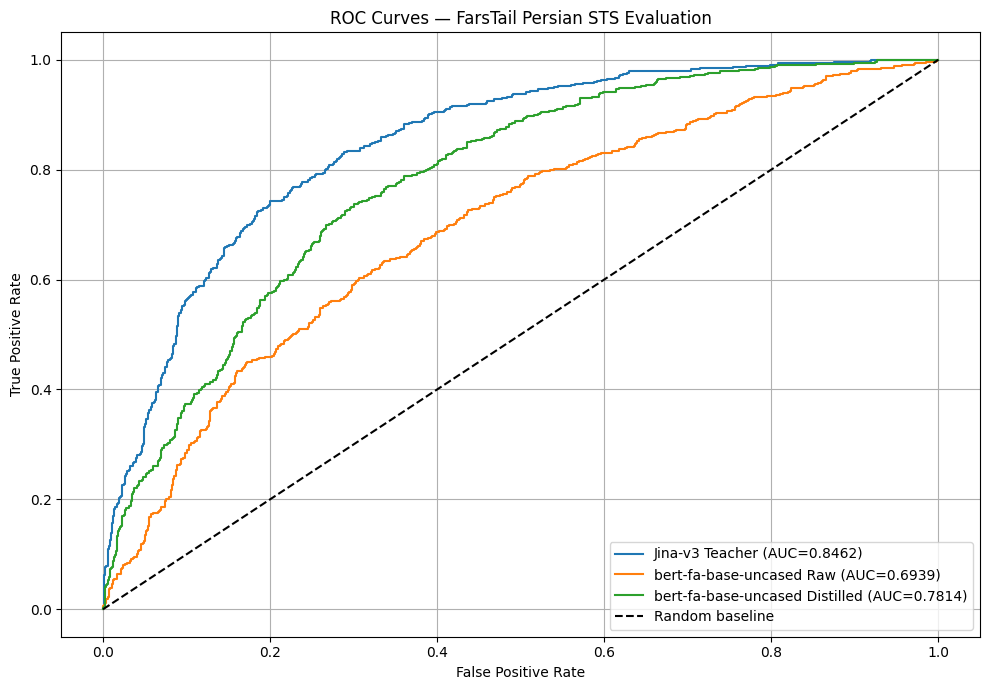


Plot saved to: /root/embed-distill/models/roc_curves.png


In [9]:
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Jina-v3   (Teacher, upper bound): {teacher_auc:.4f}")
print(f"bert-fa-base-uncased (Raw baseline):        {raw_auc:.4f}")
print(f"bert-fa-base-uncased (Distilled):           {distilled_auc:.4f}")
improvement = distilled_auc - raw_auc
gap_closed  = improvement / (teacher_auc - raw_auc) * 100 if teacher_auc != raw_auc else 0
print(f"\nImprovement over baseline: +{improvement:.4f}")
print(f"Gap to teacher closed:      {gap_closed:.1f}%")

# --- Plot ROC curves
plt.figure(figsize=(10, 7))
for name, scores, auc in [
    ('Jina-v3 Teacher',      teacher_scores,   teacher_auc),
    ('bert-fa-base-uncased Raw',      raw_scores,       raw_auc),
    ('bert-fa-base-uncased Distilled',distilled_scores, distilled_auc),
]:
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — FarsTail Persian STS Evaluation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'roc_curves.png'))
plt.show()

print(f"\nPlot saved to: {os.path.join(MODEL_DIR, 'roc_curves.png')}")